In [60]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from model.model import unet
import torch
import torch.nn as nn
print(torch.cuda.device_count())
import h5py
from scipy import signal
devc = torch.device('cpu')
from scipy.signal import butter, filtfilt
import torch.nn.functional as F

1


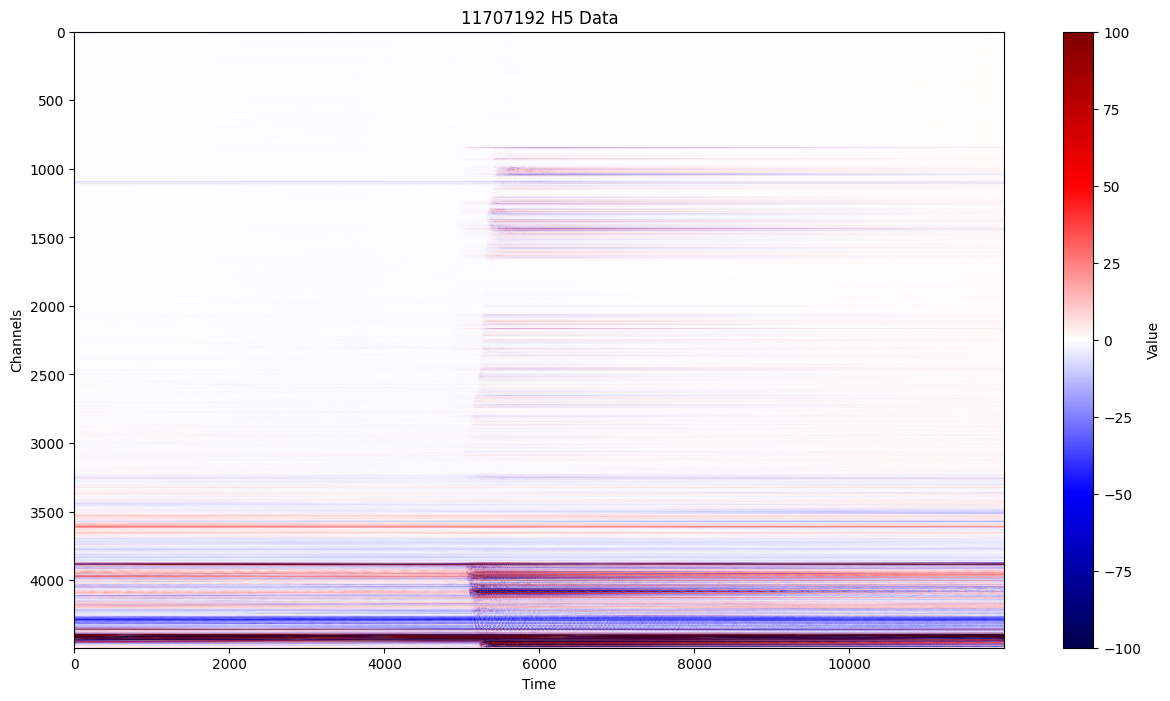

(12000, 4494)


In [61]:
# Load the .h5 file
file_path = "/1-fnp/petasaur/p-jbod1/rainier/2023/08/27/decimator_2023-08-27_10.10.00_UTC.h5"

# Load the data
with h5py.File(file_path, 'r', locking=False) as f:
    data = f['Acquisition/Raw[0]/RawData'][:]
    data_time = f['Acquisition/Raw[0]/RawDataTime'][:]
    data_sample_count = f['Acquisition/Raw[0]/RawDataSampleCount'][:]

    
# Plot the data
plt.figure(figsize=(15, 8))
plt.imshow(data.T, aspect='auto', cmap='seismic', vmin=-1e2, vmax=1e2)
plt.colorbar(label='Value')
plt.title("11707192 H5 Data")
plt.xlabel("Time")
plt.ylabel("Channels")
plt.show()
print(data.shape)

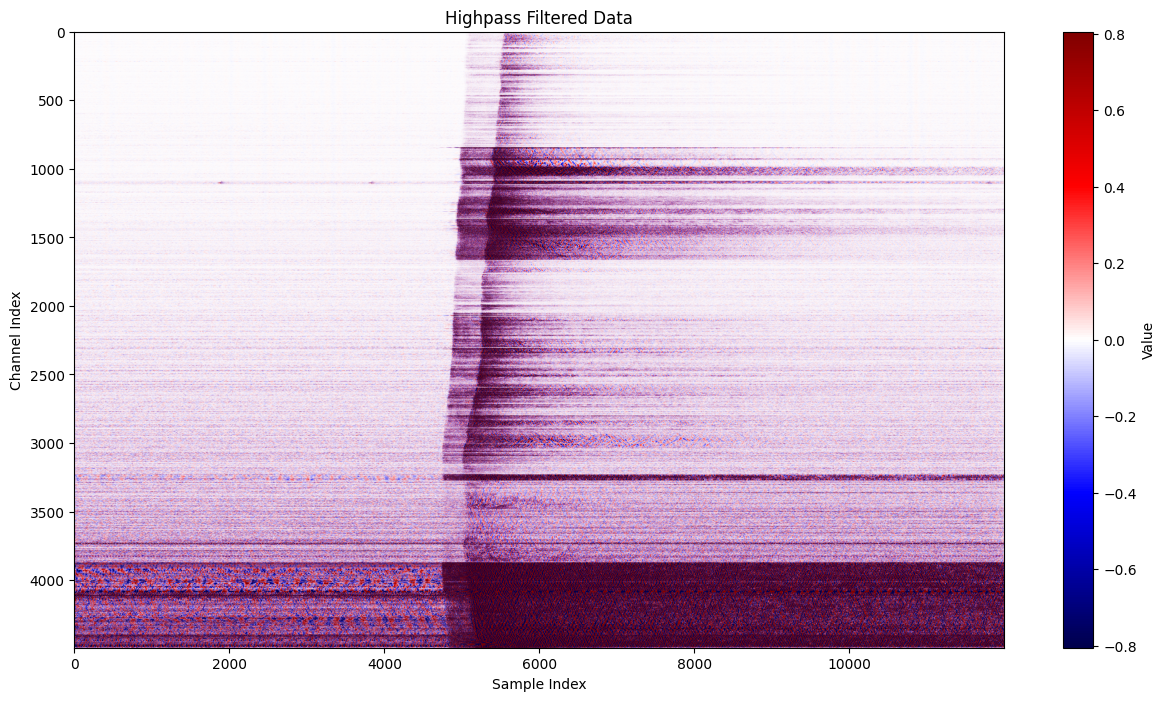

In [62]:
# Define highpass filter
def highpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

# Apply highpass filter to the data
fs = 200  # Sampling frequency (Hz)
cutoff = 1  # Cutoff frequency (Hz)
filtered_data = highpass_filter(data, cutoff, fs)

filtered_data_max = np.max(np.abs(filtered_data))

filtered_data_max = np.percentile(np.abs(filtered_data), 90)

# Plot the filtered data
plt.figure(figsize=(15, 8))
plt.imshow(filtered_data.T, aspect='auto', cmap='seismic', vmin=-filtered_data_max, vmax=filtered_data_max)
plt.colorbar(label='Value')
plt.title("Highpass Filtered Data")
plt.xlabel("Sample Index")
plt.ylabel("Channel Index")
plt.show()

In [63]:
""" Initialize the U-net model """
print(f"Using device: {devc}")
model_1 = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
# model_1 = nn.DataParallel(model_1, device_ids=[1,2,3])
model_1.to(devc)

""" Load the pretrained weights """
state_dict = torch.load('/home/ajm76/FM_Denoising_DAS/model/denoiser_weights_LR08_MASK05_raw2raw_old.pt', map_location='cpu')

# Remove 'module.' prefix from keys if the model was trained with DataParallel
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith('module.'):
        new_state_dict[k[7:]] = v  # remove 'module.' prefix
    else:
        new_state_dict[k] = v
        
model_1.load_state_dict(new_state_dict)
model_1.eval()

Using device: cpu


unet(
  (relu): ReLU()
  (layer): ModuleList(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxBlurPool2d()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxBlurPool2d()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): MaxBlurPool2d()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Dropout(p=0.2, inplace=False)
    (12): MaxBlurPool2d()
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): Dropout(p=0.2, inplace=False)
    (16): Upsa

In [64]:
data = filtered_data[:1500, 4000:5500]
data_norm = (data - np.mean(data)) / np.std(data)
data_tensor = torch.from_numpy(data_norm).to(devc)
print(data_tensor.shape)

torch.Size([1500, 494])


In [65]:
def pad_input_to_square(tensor, target_size=(1500, 1500)):
    """
    Pads a 2D or 3D tensor (e.g., [1500, 494] or [1, 1500, 494]) to the target size.
    Assumes padding only on the right and bottom.
    """
    if len(tensor.shape) == 2:
        tensor = tensor.unsqueeze(0)  # [C, W] → [1, C, W]
    if len(tensor.shape) == 3:
        tensor = tensor.unsqueeze(0)  # [C, H, W] → [1, C, H, W]
    
    _, _, h, w = tensor.shape
    pad_h = target_size[0] - h
    pad_w = target_size[1] - w

    padded_tensor = F.pad(tensor, (0, pad_w, 0, pad_h))  # (left, right, top, bottom)
    return padded_tensor, (h, w)  # return original shape to crop later

def crop_output_to_original(output, original_shape):
    """
    Crops the output tensor back to the original shape.
    """
    _, _, h, w = output.shape
    target_h, target_w = original_shape
    return output[:, :, :target_h, :target_w]


In [66]:
# Run the model on the output 4 times
num_iterations = 4

# Pad the input tensor to the target size
data_tensor, original_shape = pad_input_to_square(data_tensor)
current_input = data_tensor.float()

for _ in range(num_iterations):
    current_output = model_1(current_input)
    current_input = current_output

# Convert final output back to NumPy for visualization
output_numpy = current_output.detach().numpy().squeeze()

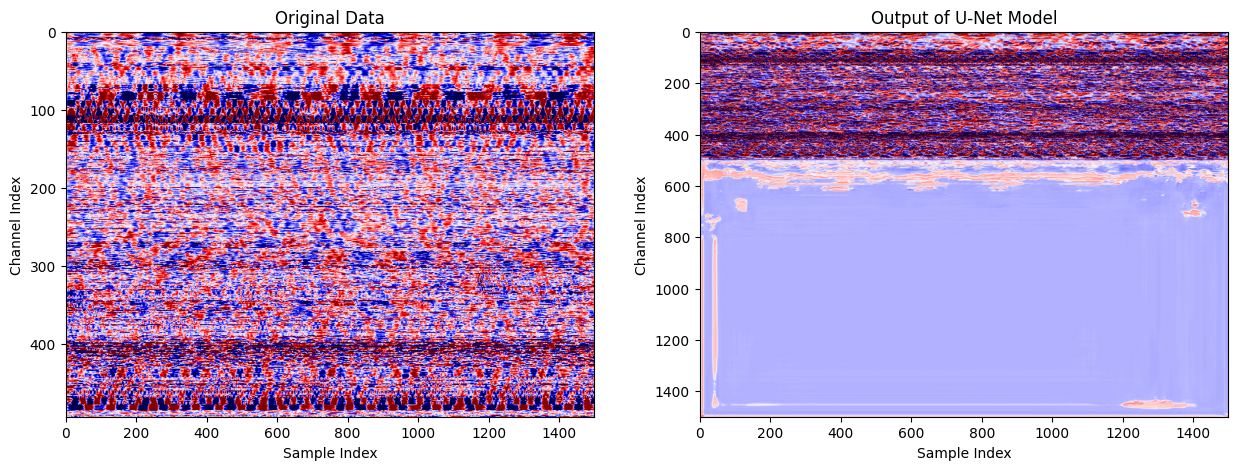

0.18910950869321824


In [67]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
data_max = np.percentile(np.abs(data_norm), 90)
output_max =  np.percentile(np.abs(output_numpy), 90)

# Plot original data
axs[0].imshow(data_norm.T, aspect='auto', cmap='seismic', vmin=-data_max, vmax=data_max, interpolation=None)
axs[0].set_title('Original Data')
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Channel Index')

# Plot U-Net output
axs[1].imshow(output_numpy.T, aspect='auto', cmap='seismic', vmin=-output_max, vmax=output_max, interpolation=None)
axs[1].set_title('Output of U-Net Model')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Channel Index')

plt.show()
print(output_max)